In [46]:
# Third-party library imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Local imports
import utils

In [47]:
# Constants and configurations
TRAIN_SIZE = 6000
RANDOM_SEED = 42  # Add randomization for reproducibility

# Data loading with error handling
def load_data(ham_path='hammas_text', idf_path='idf_text'):
    try:
        hammas_text = pd.read_pickle(ham_path)
        idf_text = pd.read_pickle(idf_path)
        return hammas_text.tolist(), idf_text.tolist()
    except Exception as e:
        print(f"Error loading data: {e}")
        return None, None

# Split data with clear function
def train_test_split(ham_data, idf_data, train_size):
    
    #choosing shortest of lists to balance the other one for the training
    shortest_list = len(min(ham_data, idf_data, key=len))
    
    train_ham = ham_data[:train_size]
    test_ham = ham_data[train_size:shortest_list]
    train_idf = idf_data[:train_size]
    test_idf = idf_data[train_size:shortest_list]
    return train_ham, test_ham, train_idf, test_idf

In [48]:
#Loading input data
ham_data, idf_data = load_data()
train_ham, test_ham, train_idf, test_idf = train_test_split(ham_data, idf_data, TRAIN_SIZE)
train_x = train_ham + train_idf
test_x = test_ham + test_idf

# combine Hamas and IDF labels
train_y = np.append(np.ones(len(train_ham)), np.zeros(len(train_idf)))
test_y = np.append(np.ones(len(test_ham)), np.zeros(len(test_idf)))

# Print the shape train and test sets
print("train_y.shape = " + str(train_y.shape))
print("test_y.shape = " + str(test_y.shape))
print("train_x.shape = " + str(len(train_x)))
print("test_x.shape = " + str(len(test_x)))

train_y.shape = (12000,)
test_y.shape = (4452,)
train_x.shape = 12000
test_x.shape = 4452


# Train your model using Naive Bayes

Naive bayes is an algorithm that could be used for sentiment analysis. It takes a short time to train and also has a short prediction time.

#### So how do you train a Naive Bayes classifier?
- The first part of training a naive bayes classifier is to identify the number of classes that you have.
- You will create a probability for each class.
$P(D_{ham})$ is the probability that the document is Hamas.
$P(D_{idf})$ is the probability that the document is IDF.
Use the formulas as follows and store the values in a dictionary:

$$P(D_{ham}) = \frac{D_{ham}}{D}\tag{1}$$

$$P(D_{idf}) = \frac{D_{idf}}{D}\tag{2}$$

Where $D$ is the total number of documents, or texts in this case, $D_{ham}$ is the total number of Hamas texts and $D_{idf}$ is the total number of IDF texts.

#### Prior and Logprior

The prior probability represents the underlying probability in the target population that a text is Hamas versus IDF.  In other words, if we had no specific information and blindly picked a text out of the population set, what is the probability that it will be Hamas versus that it will be IDF? That is the "prior".

The prior is the ratio of the probabilities $\frac{P(D_{ham})}{P(D_{idf})}$.
We can take the log of the prior to rescale it, and we'll call this the logprior

$$\text{logprior} = log \left( \frac{P(D_{ham})}{P(D_{idf})} \right) = log \left( \frac{D_{ham}}{D_{idf}} \right)$$.

Note that $log(\frac{A}{B})$ is the same as $log(A) - log(B)$.  So the logprior can also be calculated as the difference between two logs:

$$\text{logprior} = \log (P(D_{ham})) - \log (P(D_{idf})) = \log (D_{ham}) - \log (D_{idf})\tag{3}$$

#### Positive and Negative Probability of a Word
To compute the Hamas probability and the IDF probability for a specific word in the vocabulary, we'll use the following inputs:

- $freq_{ham}$ and $freq_{idf}$ are the frequencies of that specific word in the Hamas or IDF class. In other words, the Hamas frequency of a word is the number of times the word is counted with the label of 1.
- $N_{ham}$ and $N_{idf}$ are the total number of Hamas and IDF words for all documents (for all texts), respectively.
- $V$ is the number of unique words in the entire set of documents, for all classes, whether Hamas or IDF.

We'll use these to compute the Hamas and IDF probability for a specific word using this formula:

$$ P(W_{ham}) = \frac{freq_{ham} + 1}{N_{ham} + V}\tag{4} $$
$$ P(W_{idf}) = \frac{freq_{idf} + 1}{N_{idf} + V}\tag{5} $$

Notice that we add the "+1" in the numerator for additive smoothing.  This [wiki article](https://en.wikipedia.org/wiki/Additive_smoothing) explains more about additive smoothing.

#### Log likelihood
To compute the loglikelihood of that very same word, we can implement the following equations:

$$\text{loglikelihood} = \log \left(\frac{P(W_{ham})}{P(W_{idf})} \right)\tag{6}$$

##### Create `freqs` dictionary
- Given your `count_texts` function, you can compute a dictionary called `freqs` that contains all the frequencies.
- In this `freqs` dictionary, the key is the tuple (word, label)
- The value is the number of times it has appeared.

We will use this dictionary in several parts of this assignment.

In [49]:
freqs = utils.count_texts({}, train_x, train_y)
logprior, loglikelihood = utils.train_naive_bayes(freqs, train_x, train_y)
print(logprior)
print(len(loglikelihood))
print("Naive Bayes accuracy = %0.4f" %
      (utils.test_naive_bayes(test_x, test_y, logprior, loglikelihood)))

0.0
18663


### Frequency visualisation

- Now we can visualise the top 50 words taking into account words with more than 3 characters
- Also number of words against their frequency in the text
- Using WordCloud create a picture of most used words

In [100]:
sorted_freqs = dict(sorted(freqs.items(), key=lambda item: item[1], reverse=True))

# Extracting the top 50 items
top_50_items = list(sorted_freqs.items())[:50]

# Extract just the words from the top 50 items
top_50_words = [key[0] for key, value in top_50_items]

# Filtering words with more than 3 characters
filtered_words = [word for word in top_50_words if len(word) > 3]

# Print the filtered list of words
print(filtered_words)

# each element consist of a sublist with this pattern: [<word>, <Hamas_count>, <IDF_count>]
data = []

# loop through our selected words
for word in filtered_words:

    # initialize Hamas and IDF counts
    ham = 0
    idf = 0

    # retrieve number of Hamas counts
    if (word, 1) in freqs:
        ham = freqs[(word, 1)]

    # retrieve number of IDF counts
    if (word, 0) in freqs:
        idf = freqs[(word, 0)]

    # append the word counts to the table
    data.append([word, ham, idf])


['resist', 'report', 'gaza', 'area', 'siren', 'sound', 'initi', 'martyr', 'link', 'strip', 'fighter', 'follow', 'terrorist', 'soldier', 'occup', 'palestinian', 'zionist', 'oper', 'forc', 'forc', 'israel', 'activ', 'detail', 'suspect', 'jenin', 'nablu', 'brigad', 'surround', 'hama', 'peopl', 'target', 'prison', 'allah', 'attach', 'isra', 'fire', 'command', 'citi', 'fire', 'near', 'terror']


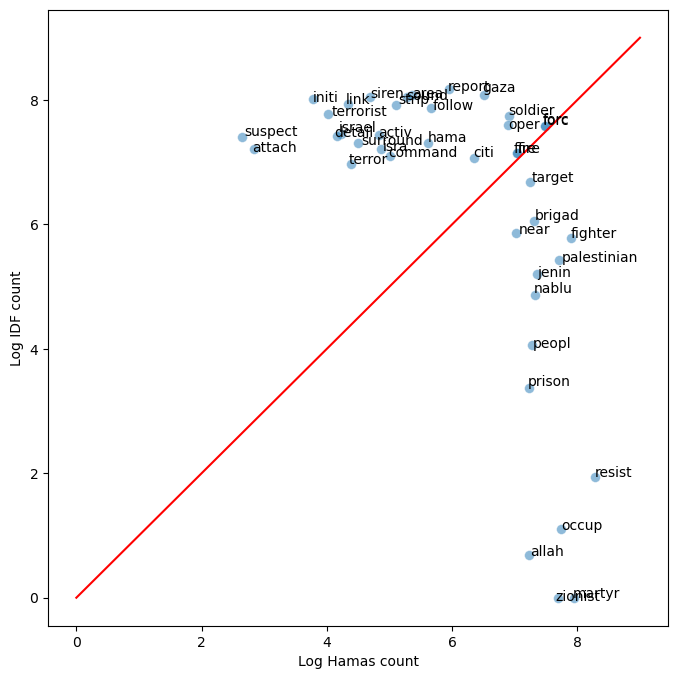

In [101]:
# convert raw counts to logarithmic scale. we add 1 to avoid log(0)
x = np.log([x[1] + 1 for x in data])
y = np.log([x[2] + 1 for x in data])

# Create a scatter plot with smaller, transparent markers
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(x, y, s=50, alpha=0.5, edgecolors='w', linewidth=0.5)

# Assign axis labels
plt.xlabel("Log Hamas count")
plt.ylabel("Log IDF count")

# Add jitter to the annotations to reduce overlap
jitter = 0.05
for i in range(len(data)):
    ax.annotate(data[i][0], (x[i] + np.random.uniform(-jitter, jitter), y[i] + np.random.uniform(-jitter, jitter)), fontsize=10)

# Plot the red line that divides the 2 areas
ax.plot([0, 9], [0, 9], color='red')

plt.show()

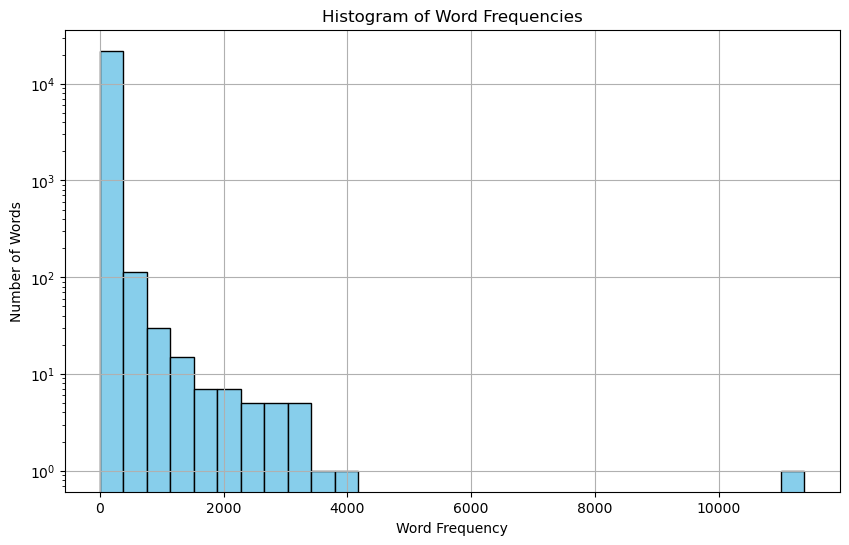

In [102]:
# Extract word frequencies
word_frequencies = [count for (word, label), count in freqs.items()]

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(word_frequencies, bins=30, color='skyblue', edgecolor='black', log=True)
plt.xlabel('Word Frequency')
plt.ylabel('Number of Words')
plt.title('Histogram of Word Frequencies')
plt.grid(True)
plt.show()

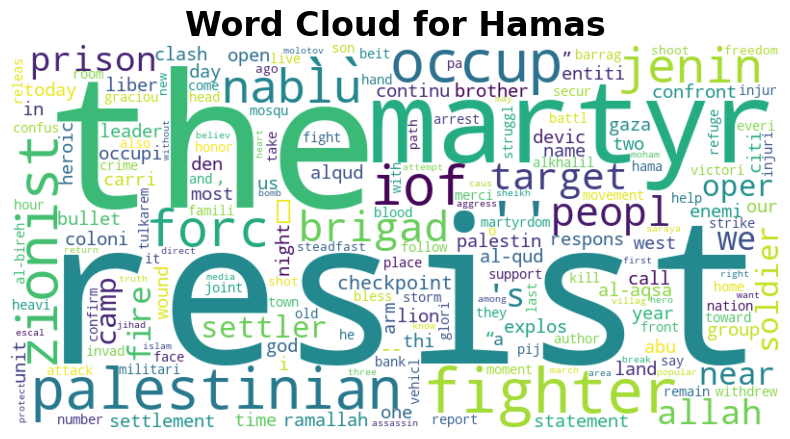

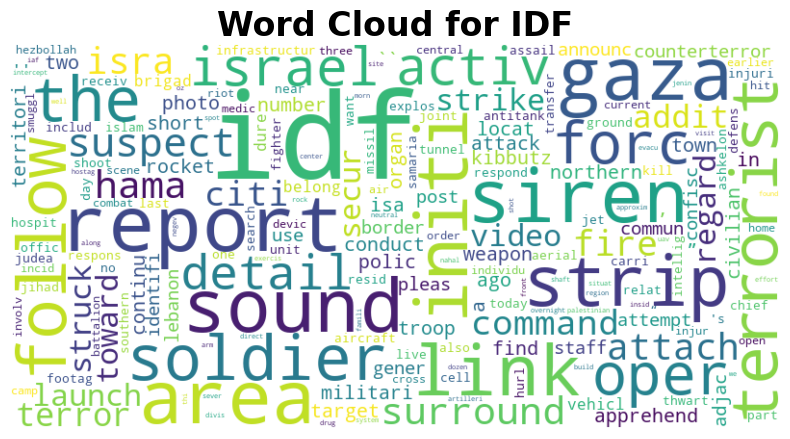

In [103]:
# Visualising mostused words using Wordcloud library

def plot_word_cloud(freqs, label, fontdict):
    # Filter words by label
    words = {word: count for (word, lbl), count in freqs.items() if lbl == label}
    
    # Generate word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(words)
    
    # Plot word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Word Cloud for {'Hamas' if label == 1 else 'IDF'}", fontdict = fontdict)
    plt.show()

fontdict = {'fontsize': 24, 'fontweight': 'bold'}
    
# Plot word clouds for both classes
plot_word_cloud(freqs, label=1, fontdict=fontdict)
plot_word_cloud(freqs, label=0, fontdict=fontdict)

### Results 

Are quite surprisingly better than the ones from logistic regression morel.

In [51]:
for text in ['Our fighters sniped a zionist soldier on the "Netzarim" axis south of Gaza City.', 
             'IDF: Following the sirens that sounded in the area of Shlomit a short while ago, it was determined to be a false identification.']:    
    p = utils.naive_bayes_predict(text, logprior, loglikelihood)
    print(f'{text} -> {p:.2f}')

Our fighters sniped a zionist soldier on the "Netzarim" axis south of Gaza City. -> 15.80
IDF: Following the sirens that sounded in the area of Shlomit a short while ago, it was determined to be a false identification. -> -29.36


# Filter words by Ratio of IDF to Hamas counts

- Some words have more Hamas counts than others, and can be considered "more Hamas".  Likewise, some words can be considered more IDF than others.
- One way for us to define the level of Hamasness or IDFness, without calculating the log likelihood, is to compare the Hamas to IDF frequency of the word.
    - Note that we can also use the log likelihood calculations to compare relative relationship of words.
- We can calculate the ratio of Hamas to IDF frequencies of a word.
- Once we're able to calculate these ratios, we can also filter a subset of words that have a minimum ratio of Hamas / IDF or higher.
- Similarly, we can also filter a subset of words that have a maximum ratio of Hamas / IDF or lower (words that are at least as IDF, or even more IDF than a given threshold).

#### Implement get_ratio
- Given the freqs dictionary of words and a particular word, use `lookup(freqs,word,1)` to get the Hamas count of the word.
- Similarly, use the `lookup` function to get the IDF count of that word.
- Calculate the ratio of Hamas divided by IDF counts

$$ ratio = \frac{\text{ham_words} + 1}{\text{IDF_words} + 1} $$

Where ham_words and IDF_words correspond to the frequency of the words in their respective classes. 
<table>
    <tr>
        <td>
            <b>Words</b>
        </td>
        <td>
        Hamas word count
        </td>
         <td>
        IDF Word Count
        </td>
  </tr>
    <tr>
        <td>
        glad
        </td>
         <td>
        41
        </td>
    <td>
        2
        </td>
  </tr>
    <tr>
        <td>
        arriv
        </td>
         <td>
        57
        </td>
    <td>
        4
        </td>
  </tr>
    <tr>
        <td>
        :(
        </td>
         <td>
        1
        </td>
    <td>
        3663
        </td>
  </tr>
    <tr>
        <td>
        :-(
        </td>
         <td>
        0
        </td>
    <td>
        378
        </td>
  </tr>
</table>

#### Implement get_words_by_threshold(freqs,label,threshold)

* If we set the label to 1, then we'll look for all words whose threshold of Hamas/IDF is at least as high as that threshold, or higher.
* If we set the label to 0, then we'll look for all words whose threshold of Hamas/IDF is at most as low as the given threshold, or lower.
* Use the `get_ratio` function to get a dictionary containing the Hamas count, IDF count, and the ratio of Hamas to IDF counts.
* Append the `get_ratio` dictionary inside another dictinoary, where the key is the word, and the value is the dictionary `ham_idf_ratio` that is returned by the `get_ratio` function.
An example key-value pair would have this structure:
```
{'happi':
    {'Hamas': 10, 'IDF': 20, 'ratio': 0.524}
}
```

In [52]:
# Test your function: find IDF words at or below a threshold
utils.get_words_by_threshold(freqs, label=0, threshold=0.005)

{'apprehend': {'hammas': 1, 'idf': 883, 'ratio': 0.0022624434389140274},
 'isa': {'hammas': 1, 'idf': 715, 'ratio': 0.002793296089385475},
 'idf': {'hammas': 0, 'idf': 11384, 'ratio': 8.78348704435661e-05},
 'overnight': {'hammas': 0, 'idf': 229, 'ratio': 0.004347826086956522},
 'assail': {'hammas': 0, 'idf': 283, 'ratio': 0.0035211267605633804},
 'judea': {'hammas': 0, 'idf': 391, 'ratio': 0.002551020408163265},
 'samaria': {'hammas': 0, 'idf': 279, 'ratio': 0.0035714285714285713},
 'iaf': {'hammas': 0, 'idf': 214, 'ratio': 0.004651162790697674},
 'antitank': {'hammas': 0, 'idf': 299, 'ratio': 0.0033333333333333335},
 'counterterror': {'hammas': 0, 'idf': 446, 'ratio': 0.0022371364653243847}}

In [53]:
# Test your function; find Hamas words at or above a threshold
word_data = utils.get_words_by_threshold(freqs, label=1, threshold=10)

# Print the header
print(f"{'Word':<15} | {'Hamas Count':<12} | {'IDF Count':<10} | {'Hamas/IDF Ratio':<15}")
print("-" * 60)

# Print each word's data
for word, data in word_data.items():
    hammas_count = data['hammas']
    idf_count = data['idf']
    ratio = data['ratio']
    print(f"{word:<15} | {hammas_count:<12} | {idf_count:<10} | {ratio:<15.2f}")

Word            | Hamas Count  | IDF Count  | Hamas/IDF Ratio
------------------------------------------------------------
news            | 100          | 1          | 50.50          
resist          | 3933         | 6          | 562.00         
palestin        | 829          | 10         | 75.45          
amplifi         | 27           | 0          | 28.00          
voic            | 95           | 6          | 13.71          
martyr          | 2827         | 0          | 2828.00        
prison          | 1387         | 28         | 47.86          
farmer          | 15           | 0          | 16.00          
refuge          | 282          | 23         | 11.79          
coloni          | 834          | 0          | 835.00         
occup           | 2279         | 2          | 760.00         
tear            | 65           | 2          | 22.00          
youth           | 152          | 4          | 30.60          
nablu           | 1521         | 129        | 11.71          
young    

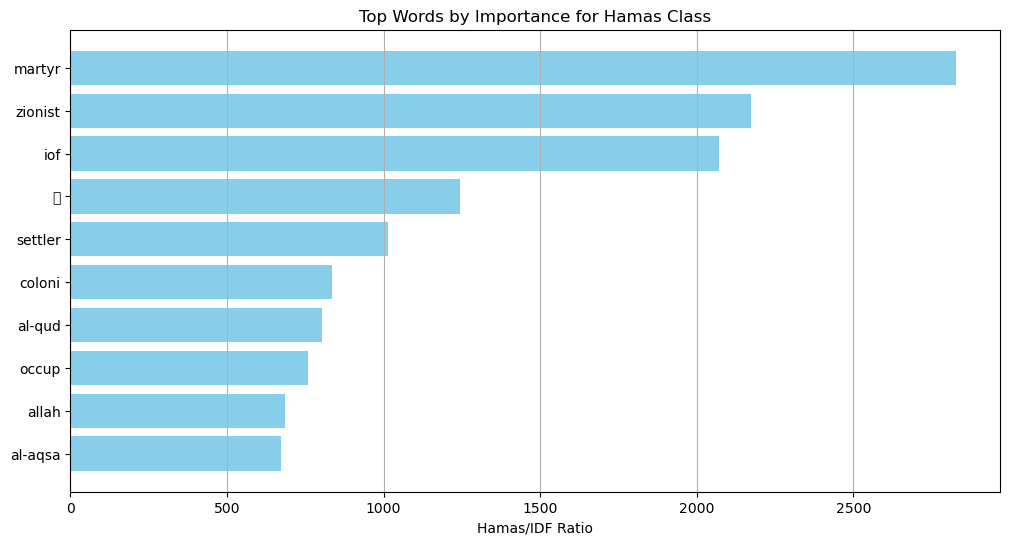

In [123]:
word_importance = utils.get_words_by_threshold(freqs, label=1, threshold=10)

# Sort words by their importance ratio
sorted_words = sorted(word_importance.items(), key=lambda item: item[1]['ratio'], reverse=True)

# Select the top 10 words
top_words = sorted_words[:10]

# Extract words and their importance ratios
words = [word for word, data in top_words]
ratios = [data['ratio'] for word, data in top_words]

# Plot the bar chart
plt.figure(figsize=(12, 6))
plt.barh(words, ratios, color='skyblue')
plt.xlabel('Hamas/IDF Ratio')
plt.title('Top Words by Importance for Hamas Class')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest ratio on top
plt.grid(True, axis='x')
plt.show()

In [60]:
# Some error analysis done for you
print('Truth Predicted Text')
for x, y in zip(test_x, test_y):
    y_hat = utils.naive_bayes_predict(x, logprior, loglikelihood)
    if y != (np.sign(y_hat) > 0):
        print('%d\t%0.2f\t%s' % (y, np.sign(y_hat) > 0, ' '.join(
            utils.process_text(x)).encode('ascii', 'ignore')))


Truth Predicted Text
1	0.00	b'five injuri report ministri health gaza follow iof bomb strip yesterday'
1	0.00	b' explos report khan yuni gaza strip zionist forc launch strike citi detail emerg'
1	0.00	b'over 300 rocket launch gaza last three hour'
1	0.00	b'local sourc report  isra  drone fire two missil toward hous town qarara east khan youni gaza'
1	0.00	b'a warehous occupi asqalan significantli damag hit rocket fire gaza'
1	0.00	b' the palestinian resist gaza launch round missil toward  kerem shalom  south gaza envelop'
1	0.00	b"a fire broke hous beit hanoun northern gaza `` iron dome '' missil fell tri intercept resist 's rocket no injuri report"
1	0.00	b'three injuri arriv indonesian hospit result recent bomb town beit lahia northern gaza strip.th iof current conduct new raid central gaza'
1	0.00	b"footag recent launch rocket gaza toward `` sderot ''"
0	1.00	b"an honest investig part armi  dna we constantli investig thi idf way learn improv the idf respons secur state commit improv

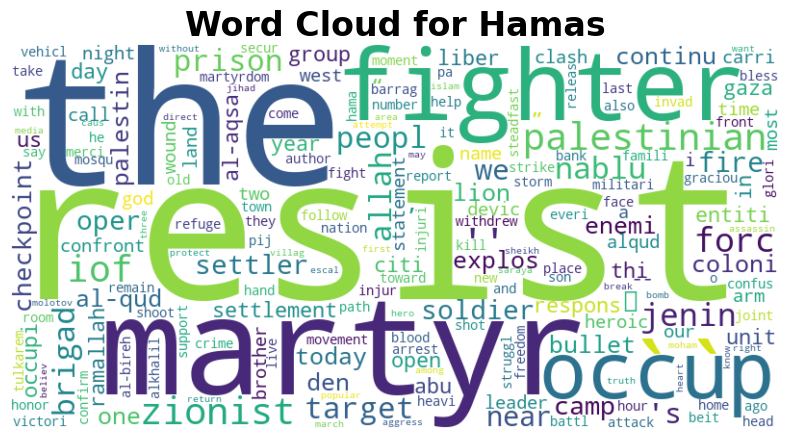

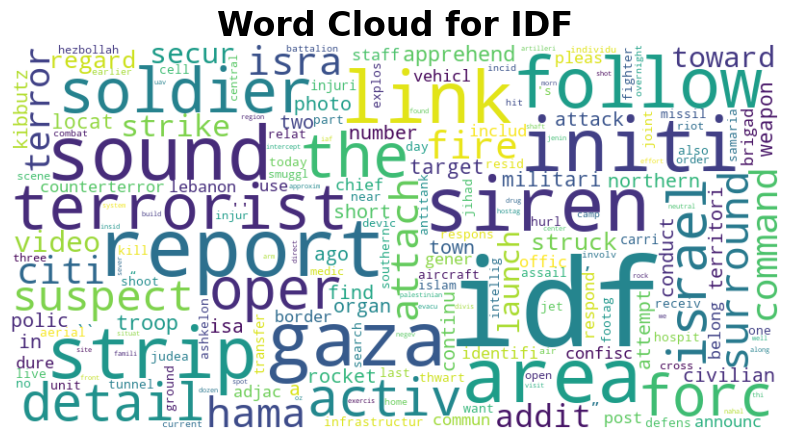